Assignment 3

Machine Learning CS6140

By Arjun Patel

# Assignment Requirements

1. Develop a tutorial ipython note that explains 'Complementary Slackness' condition using 2D data example.

2. Explore the solution space for half-circles and moons dataset also provided in code of Module 6
    - Find best kernel function
    - Visualize and explain solution

3. Train a simplest possible MLP to solve the same classification problems of task 2. (5)
    - Explain rational behind your training process and design parameters
    - Compare SVM and MLP solution in terms of computational cost
    - Apply k-Fold cross validation for both task 2 and 3.

## Complementary Slackness

Before looking at complementary slackness, we need to look at Karush-Kuhn-Tucker (KKT) conditions in the context of support vector machines (SVM) to understand complementary slackness when looking at non-linear classification problems. 

SVM, which was proposed by Vladimir Vapnik and Alexey Chervonenkis, is a type of machine learning algorithm that is used for classfication and regression analysis, which helps predict future outcomes. SVM draws the hyperplane, which is the decision line boundary, that separates groups of data according to patterns within the data and can help classify incoming datapoints. This is mainly done by maximizing the hyperplane's distance from the nearest data points of each class (also refered to as support vectors) to seperate all the data. 

KKT conditions, which were introduced by Albert W. Tucker and Harold W. Kuhn, play a important role in SVM because the KKT conditions find the optimal hyperplane that separates classes of data in non-linear classification problems. KKT conditions are five conditions that help identify whether a solution in nonlinear programming is optimal in machine learning. The four conditions are as followed:

![Alt text](<Screen Shot 2023-07-07 at 6.30.01 PM.png>)


In the context of KKT, complementary slackness condition only applies to inequality constraints and is a key condition in the KKT conditions. "For the ith inequality constraint, complementary slackness tells us that at x, either hi(x) = 0 or the corresponding dual variableui = 0. If hi(x) = 0, we say that the inequality constraint is tight at x" (Ryan Tibshirani). In other words, if a primal variable is positive, then the corresponding dual variable must be zero and vice versa.

In the next following passages, we will code and take a look at how comlementary slackness is used


In [1]:
# Import the following for the notebook
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import time as time_train
from sklearn.metrics import confusion_matrix

2023-07-16 18:24:26.524417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Create Class for sample data
class SampleData:

    # Creates a binary classification dataset
    def get_binary(self, n_samples, noise=0.05, random_state=3):
        n = n_samples
        blobs = datasets.make_blobs(n_samples=n, centers=2, n_features=2, cluster_std=2, random_state=random_state)
        return blobs[0], blobs[1]

    # Creates a moon shaped classification dataset
    def get_moon(self, n_samples, noise=0.05):
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=6)
        return noisy_moons[0], noisy_moons[1]

    # Creates a donut shaped classification dataset
    def get_donut(self, n_samples, noise=0.05, factor=0.5):
        noisy_circles = datasets.make_circles(n_samples=n_samples, factor=factor, noise=noise)
        return noisy_circles[0], noisy_circles[1]

    # Plots dataset and graphs data
    # Retrieves current axes (GCA = get current axes)
    # Scatter data and color accordingly
    # Label data
    def plot(self, X, y):
        ax = plt.gca()
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.xlabel("X axis")
        plt.ylabel("Y axis")
        plt.title("Data")
        plt.show()



In [3]:
# Create SVM Class
class SVM:

    # Initializes class with attributes
    # C to control trade off 
    # Kernel to control type of model
    # Sigma to control Radial Basis in rbf kernel
    # Degree to control degreee in poly
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):

        # Assign self.C as C
        # When it comes to the C parameter in training SVM, the parameter C is a regularization 
        # parameter that controls the trade off between achieving a low error on the training 
        # data and minimizing the complexity of the decision function
        self.C = C

        # Assign self.sigma as sigma
        # When ti comes to the sigma paramter in training RBF kernel, sigma determines the 
        # width of the kernel
        self.sigma = sigma

        # Assign self.degree as degree
        # When it comes to the degree paramter in training polyonomial kernel, degreee
        # changes the polynomial function degree
        self.degree = degree

        # Depending on the parameter input
        # If 2nd parameter is poly, change C to 1 and use polynomial_kernel
        # If 2nd parameter is rbf, change the model to rbf_kernel
        # If 2nd parameter is something else, change the model to linear_kernel (default)
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.C = 1
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
        else:
            self.kernel = self._linear_kernel

        # Assign X and Y
        # X will be input values
        # Y Will be target values
        self.X = None
        self.y = None
        
        # Alpha is the lagrangian multiplier, which indicates the weight assigned to each 
        # training example
        self.alpha = None 
        
        # Assign bias
        # Bias is the offset of the decision boundary from the origin
        self.bias = 0

        # Helper variable
        self.ones = None

    # _rbf_kernel is the Radial Basis Function, which measures the similarity between two 
    # data points in a high dimensional feature space. It calculates the pairwise euclidean
    # distances and applies the RBF formula to capture the non-linear relationship
    def _rbf_kernel(self, X_t, X):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X_t[:, np.newaxis] - X[np.newaxis, :], axis=2) ** 2)

    # _polynomial_kernel is a polynomial kernel that calculates the dot product between
    # the data points and raises it the power designated degree. This is ideal for polynomial relationships
    def _polynomial_kernel(self, X_t, X):
        return (X_t.dot(X.T)) ** self.degree

    # _linear_kernel is a linear kernel, which measures the similarity between two data
    # points in a high-dimensional feature space. However, this is ideal for linearly separable
    # datasets
    def _linear_kernel(self, X, X_t):
        return (X.dot(X_t.T))

    # Fits SVM
    # This is important because this is where complimentary slackness is used
    # X parameter is the data within X
    # y parameter is the data with y
    # lr is the learn rate 
    # Epochs is the number of iterations over the training data
    def fit(self, X, y, lr=1e-3, epochs=200):

        # Assign X and y
        self.X = X
        self.y = y

        # Assign lagrangian multiplier (alpha) and bias
        self.alpha = np.ones(X.shape[0])
        self.bias = 0 

        # Create an arry of ones 
        self.ones = np.ones(X.shape[0])

        # Multiply two matrices to get y_outer
        # (N,N) = (N,N) * (N,N)
        y_outer = np.outer(y, y)

        # multiply y_outer to kernel matrix to get pairwise similarity
        y_iy_jk_ij = y_outer * self.kernel(X, X)

        # Create a list for gains
        gains = []

        # Here we are using Complementary Slackess to ensure the appropriate values
        # are used for alpha when training our model
        # for each in range of epochs we calculate the following within the code
        for _ in range(epochs):

            # Calculate gradient
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)

            # Update alpha using gradient descent
            self.alpha = self.alpha + lr * gradient

            # This right here is complimentary slackness
            # We are updating alpha by replacing any value of alpha that is more than C
            # then we replace any alpha less than 0 with 0
            # This ensures that the complimentary slackness condition is met
            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            # Calculate gain by using the lagrangian formulation of the solution
            gain = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)

            # We then apply gain to gains
            gains.append(gain)


        # Index finds the indices of the support vectors by checking if alpha is greater than 0
        # and less than C 
        index = np.where(self.alpha > 0 & (self.alpha < self.C))[0]
        
        # b_i is the individual bias values
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))

        # self.bias will be the mean of all individual bias values we calculated
        self.bias = np.mean(b_i)

        # Return gains (used to understand loss per epochs)
        return gains


    # Creates decision function
    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.bias

    # Creates predictions
    def predict(self, X):
        return np.sign(self._decision_function(X))

    # Scores predictions
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    
    # Scores cross valdiation using 5 fold
    def cross_validation_score_mannual(self,X,Y, model, k=5, epochs = 200):
        cross_val_list = []
        for fold in range(k):
            X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=.2, random_state=fold)
            SVM_cross = SVM(C=self.C, kernel= self.kernel,sigma=self.sigma,degree=self.degree)
            SVM_cross.fit(X_train, y_train, epochs = epochs)
            cross_score = SVM_cross.score(X_train, y_train)
            cross_val_list.append(cross_score)
        cross_val_score = np.mean(cross_val_list)
        return cross_val_score

    # Plots the decision line boundary
    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)

        # Plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # Highlight the support vectors
        ax.scatter(self.X[:, 0][self.alpha > 0.], self.X[:, 1][self.alpha > 0.], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')


Scatter plot of data:


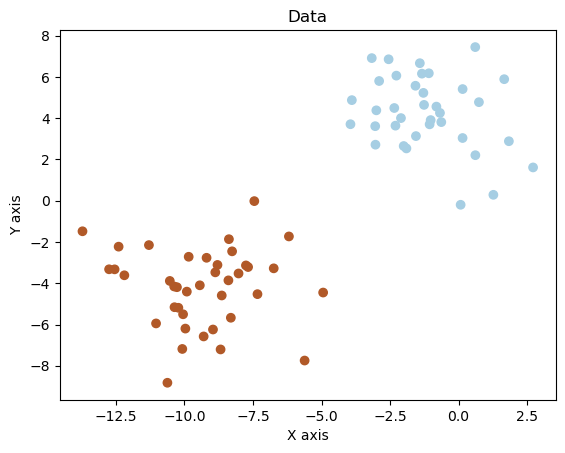

Loss per epochs for linear model:


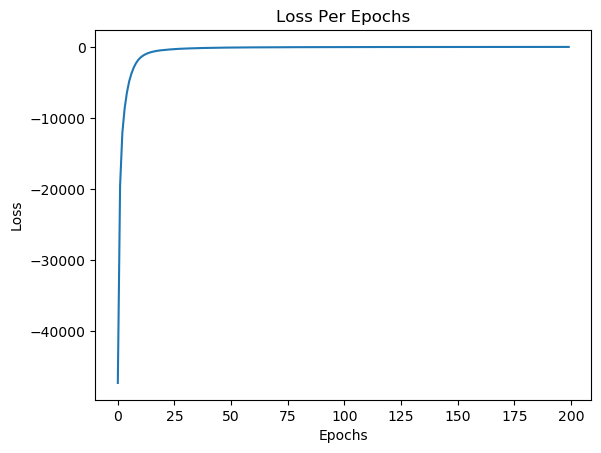

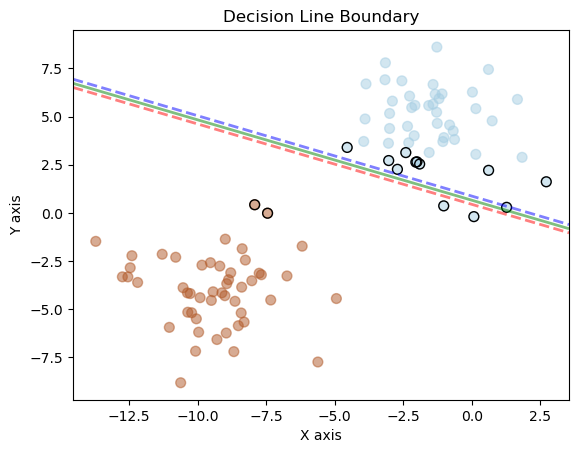

Test scores for linear
train score for linear: 0.9866666666666667
test score for linear: 0.96
cross validation score: 0.9525

Runtime: 0.97 seconds


In [4]:
# Run everything in  main
# Here we will run a linear kernel to showcase our model
# using complementary slackness
if __name__ == '__main__':
    
    # Start time to test runtime
    start_time = time.time()

    # Create Sample Data
    sample_example = SampleData()

    # Create X and Y
    X, y = sample_example.get_binary(n_samples=100, random_state=1)

    # Replace any Y values that equal 0 to -1
    y[y == 0] = -1

    # Train test split to get train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    # Plot X and y train
    print("Scatter plot of data:")
    sample_example.plot(X_train, y_train)
    plt.show()

    # Input parameters into SVM
    svm = SVM(C=1, kernel='linear')

    # Fit the SVM
    # Plot graph to show loss per epochs
    # NOTE: Please note that loss per epochs will be negative
    # for the SVM models. They should be positive, however,
    # our calculations make them negative
    print("Loss per epochs for linear model:")
    gains = svm.fit(X, y, lr=.0001)
    plt.plot(gains)
    plt.title("Loss Per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Plot decision line boundary
    svm.plot_decision_boundary()
    plt.title("Decision Line Boundary")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.show()

    # Score cross validation score
    cross_val_score = svm.cross_validation_score_mannual(X,y,"linear")

    # Print test scores
    print("Test scores for linear")
    print("train score for linear:", svm.score(X_train, y_train))
    print("test score for linear:", svm.score(X_test, y_test))
    print("cross validation score:", cross_val_score)

    # Print runtime
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")


## Exploring Solution Space for Half Circle and Moons data

In order to explore the solution space for half circle and moons data, we need to run the following SVM functions for each:

1. SVM Linear
2. SVM Poly
3. SVM RBF

Then compare all 6 outputs to understand the solution space


In [5]:
# Separate data into moon and data (X, Y) to ensure
# each solution space is using same data
X_moon, Y_moon = sample_example.get_moon(n_samples=100)
X_donut, Y_donut = sample_example.get_donut(n_samples=100)

Scatter plot of data:


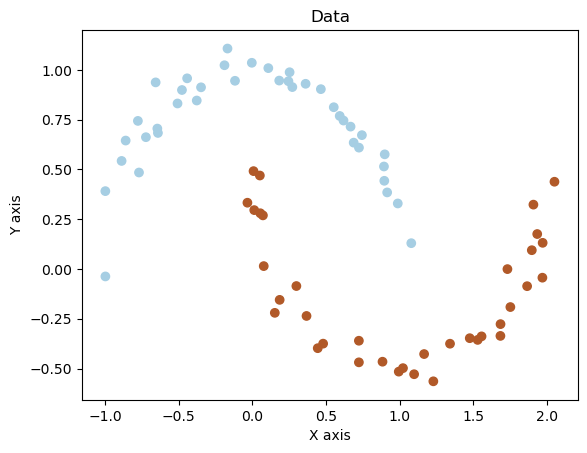

Looking at loss per epochs for


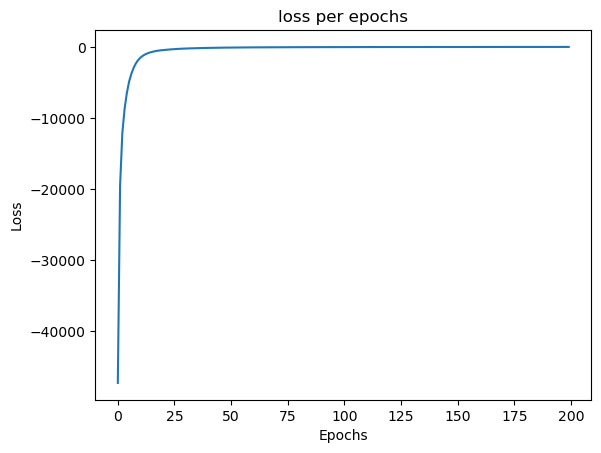

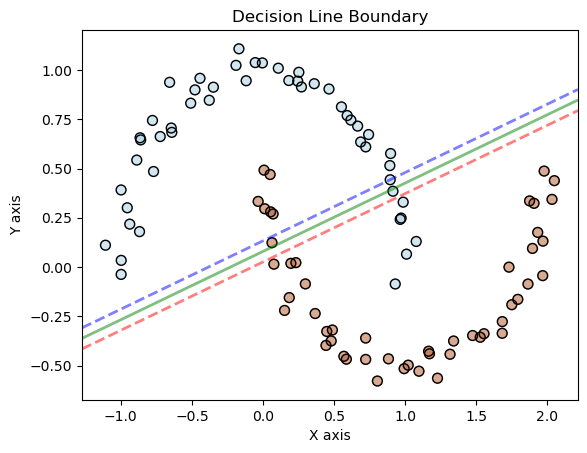

Test scores for linear moon
train score for linear moon: 0.88
test score for linear moon: 0.8
cross validation score for linear moon: 0.8800000000000001

Runtime: 0.94 seconds


In [6]:
# Checking the space solution for SVM Linear Moon
if __name__ == '__main__':
    
    # Start time to test runtime
    start_time = time.time()
    
    # Create X and Y for linear moon (LM)
    X_LM, Y_LM = X_moon, Y_moon

    # Replace any Y values that equal 0 to -1
    Y_LM[Y_LM == 0] = -1

    # Train test split to get train and test data
    X_train_LM, X_test_LM, y_train_LM, y_test_LM = train_test_split(X_LM, Y_LM, random_state=0)
    
    # Plot X and y train
    print("Scatter plot of data:")
    sample_example.plot(X_train_LM, y_train_LM)
    plt.show()

    # Input parameters into SVM
    # C = 1 
    # kernel as linear   
    SVM_LM = SVM(C=1, kernel='linear')
    
    # Fit the SVM
    # Plot graph to show loss per epochs
    print("Looking at loss per epochs for")
    SVM_LM.fit(X_LM, Y_LM, lr=.0001)
    plt.plot(gains)
    plt.title("loss per epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
        
    # Plot decision line boundary
    SVM_LM.plot_decision_boundary()
    plt.title("Decision Line Boundary")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.show()

    # Score cross validation score
    cross_val_score_LM = SVM_LM.cross_validation_score_mannual(X_LM,Y_LM, 'linear')    

    # Print test scores
    print("Test scores for linear moon")
    print("train score for linear moon:", SVM_LM.score(X_train_LM, y_train_LM))
    print("test score for linear moon:", SVM_LM.score(X_test_LM, y_test_LM))
    print("cross validation score for linear moon:", cross_val_score_LM)

    # Print runtime
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")



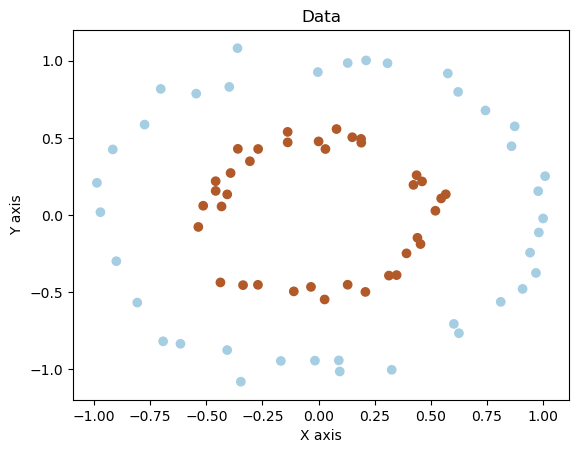

Loss per epochs for linear model:


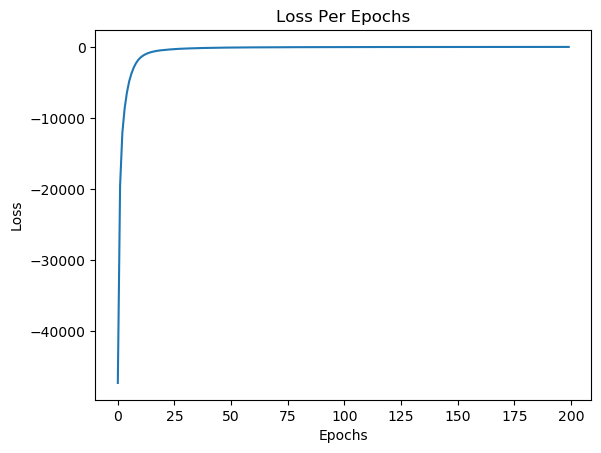

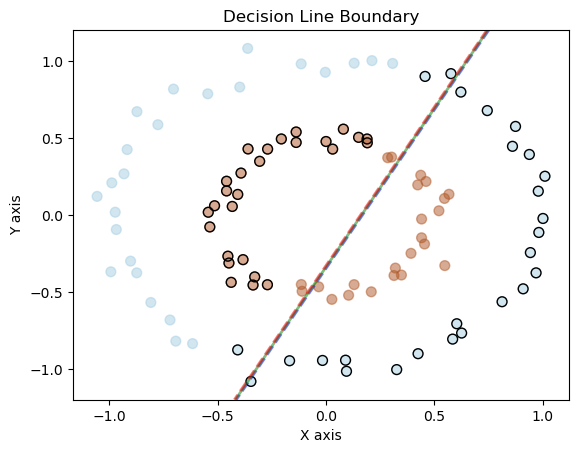

Test scores for linear donut
train score for linear donut: 0.56
test score for linear donut: 0.48
cross validation score for linear donut: 0.5375000000000001

Runtime: 0.65 seconds


In [7]:
# Checking the space solution for SVM Linear Donut
if __name__ == '__main__':

    # Start time to test runtime
    start_time = time.time()

    # Create X and Y for linear donut (LD)
    X_LD, Y_LD = X_donut, Y_donut

    # Replace any Y values that equal 0 to -1
    Y_LD[Y_LD == 0] = -1
    
    # Train test split to get train and test data
    X_train_LD, X_test_LD, y_train_LD, y_test_LD = train_test_split(X_LD, Y_LD, random_state=0)

    # Plot X and y train
    sample_example.plot(X_train_LD, y_train_LD)
    plt.show()

    # Input parameters into SVM
    # C = 1 
    # kernel as linear
    SVM_LD = SVM(C=10, kernel='linear')

    # Fit SVM
    # Plot graph to show loss per epochs
    print("Loss per epochs for linear model:")
    SVM_LD.fit(X_LD, Y_LD, lr=1)
    plt.plot(gains)
    plt.title("Loss Per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Plot decision line boundary
    SVM_LD.plot_decision_boundary()
    plt.title("Decision Line Boundary")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.show()

    # Score cross validation score
    cross_val_score_LD = SVM_LD.cross_validation_score_mannual(X_LD,Y_LD, 'linear') 

    # Print test scores
    print("Test scores for linear donut")
    print("train score for linear donut:", SVM_LD.score(X_train_LD, y_train_LD))
    print("test score for linear donut:", SVM_LD.score(X_test_LD, y_test_LD))
    print("cross validation score for linear donut:", cross_val_score_LD)

    # Print runtime
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")


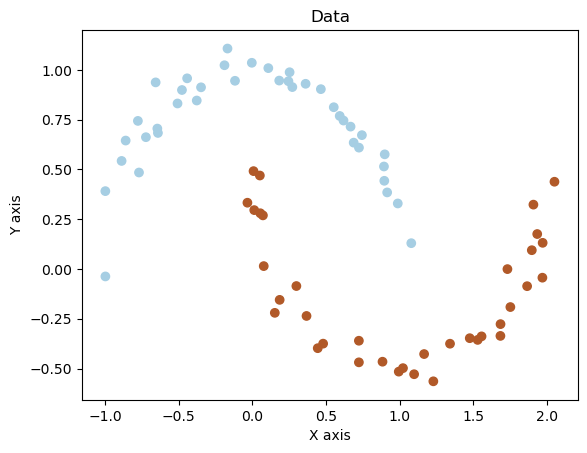

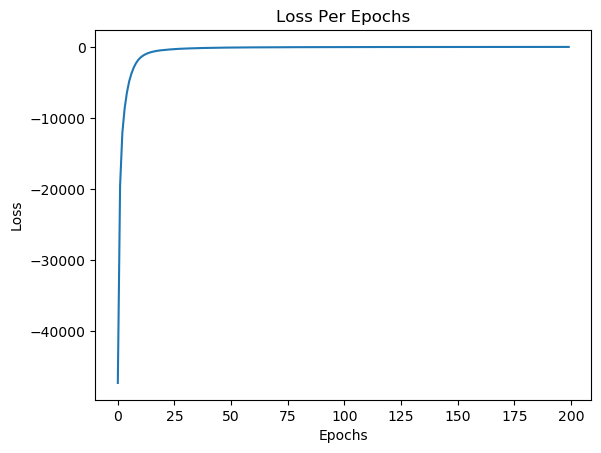

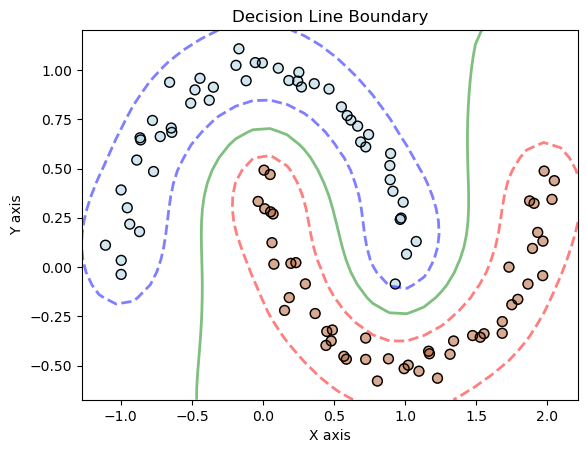

Test scores for rbf moon
train score for rbf moon: 1.0
test score for rbf moon: 1.0
cross validation score for rbf moon: 0.885

Runtime: 0.59 seconds


In [8]:
# Checking the space solution for SVM RBF Moon
if __name__ == '__main__':
    
    # Start time to test runtime
    start_time = time.time()
    
    # Create X and Y for rbf moon (rbfM)
    X_rbfM, Y_rbfM = X_moon, Y_moon

    # Replace any Y values that equal 0 to -1
    Y_rbfM[Y_rbfM == 0] = -1

    # Train test split to get train and test data
    X_train_rbfM, X_test_rbfM, y_train_rbfM, y_test_rbfM = train_test_split(X_rbfM, Y_rbfM, random_state=0)
    
    # Plot X and y train
    sample_example.plot(X_train_rbfM, y_train_rbfM)
    plt.show()

    # Input parameters into SVM
    # C = 1 
    # kernel as rbf
    SVM_rbfM = SVM(C=1, kernel='rbf',sigma=.35)

    # Fit SVM
    # Plot graph to show loss per epochs
    SVM_rbfM.fit(X_rbfM, Y_rbfM, lr=.01,epochs = 30)
    plt.plot(gains)
    plt.title("Loss Per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Plot decision line boundary
    SVM_rbfM.plot_decision_boundary()
    plt.title("Decision Line Boundary")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.show()

    # Score cross validation score
    cross_val_score_rbfM = SVM_rbfM.cross_validation_score_mannual(X_rbfM,Y_rbfM, 'rbf', epochs = 30) 

    # Print test scores
    print("Test scores for rbf moon")
    print("train score for rbf moon:", SVM_rbfM.score(X_train_rbfM, y_train_rbfM))
    print("test score for rbf moon:", SVM_rbfM.score(X_test_rbfM, y_test_rbfM))
    print("cross validation score for rbf moon:", cross_val_score_rbfM)

    # Print runtime
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")

Scatter plot of data:


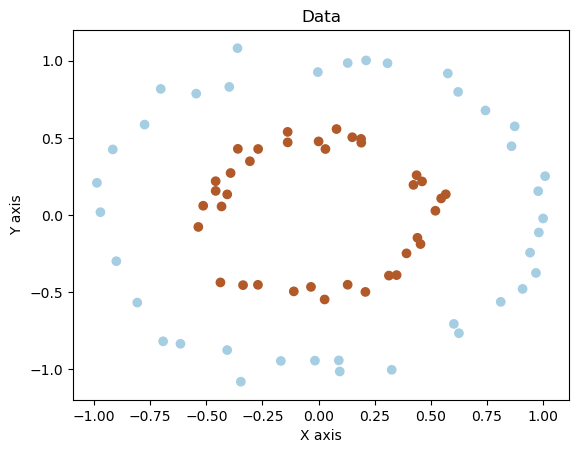

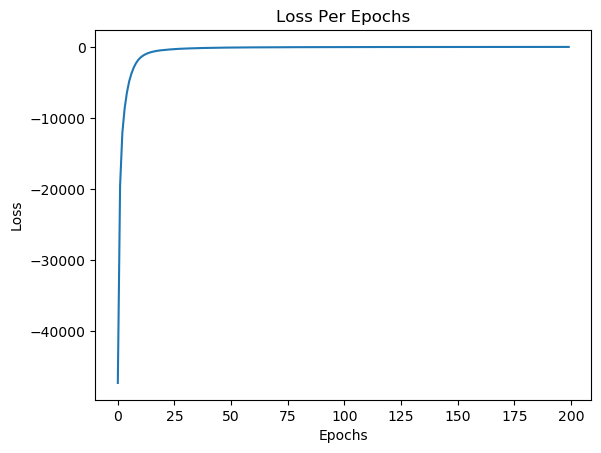

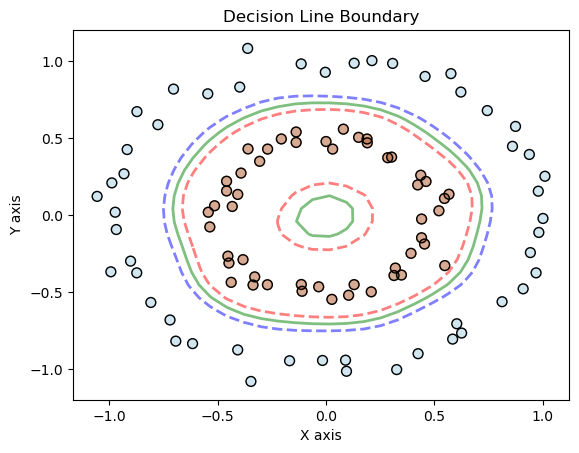

Test scores for rbf donut
test score for rbf donut: 1.0
train score for rbf donut: 1.0
cross validation score for rbf donut: 0.545

Runtime: 0.72 seconds


In [9]:
# Checking the space solution for SVM RBF Donut
if __name__ == '__main__':
    
    # Start time to test runtime
    start_time = time.time()

    # Create X and Y for rbf donut (rbfD)
    X_rbfD, Y_rbfD = X_donut, Y_donut

    # Replace any Y values that equal 0 to -1
    Y_rbfD[Y_rbfD == 0] = -1

    # Train test split to get train and test data
    X_train_rbfD, X_test_rbfD, y_train_rbfD, y_test_rbfD = train_test_split(X_rbfD, Y_rbfD, random_state=0)

    # Plot X and y train
    print("Scatter plot of data:")    
    sample_example.plot(X_train_rbfD, y_train_rbfD)
    plt.show()

    # Input parameters into SVM
    # C = 1 
    # kernel as rbf
    SVM_rbfD = SVM(C=1, kernel='rbf',sigma=.25)

    # Fit the SVM
    # Plot graph to show loss per epochs
    SVM_rbfD.fit(X_rbfD, Y_rbfD, lr=.75,epochs=30)
    plt.plot(gains)
    plt.title("Loss Per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Plot decision line boundary
    SVM_rbfD.plot_decision_boundary()
    plt.title("Decision Line Boundary")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.show()

    # Score cross validation score
    cross_val_score_rbfD = SVM_rbfD.cross_validation_score_mannual(X_rbfD,Y_rbfD, 'rbf',epochs=30)

    # Print test scores
    print("Test scores for rbf donut")
    print("test score for rbf donut:", SVM_rbfD.score(X_test_rbfD, y_test_rbfD))
    print("train score for rbf donut:", SVM_rbfD.score(X_train_rbfD, y_train_rbfD))        
    print("cross validation score for rbf donut:", cross_val_score_rbfD)

    # Print runtime
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")

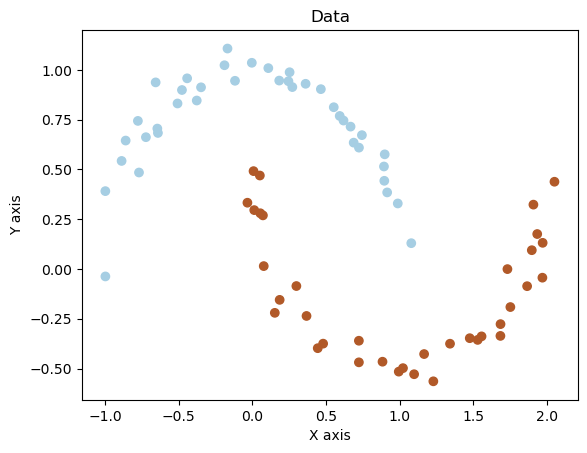

Loss per epochs for linear model:


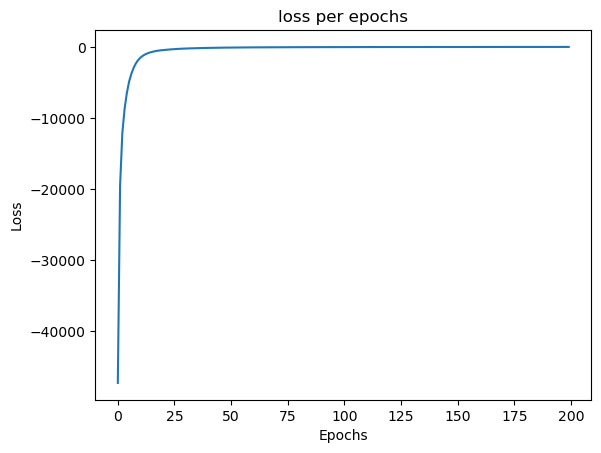

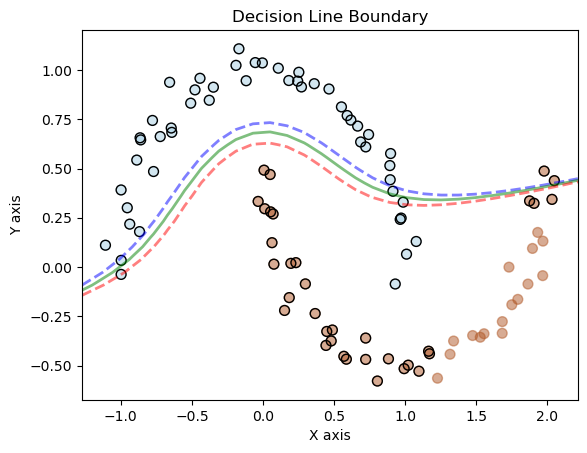

Test scores for polynomial moon
train score for polynomial moon: 0.9466666666666667
test score for polynomial moon: 0.8
cross validation score for poly moon: 0.8800000000000001

Runtime: 0.71 seconds


In [10]:
# Checking the space solution for SVM Polynomial Moon
if __name__ == '__main__':

    # Start time to test runtime
    start_time = time.time()

    # Create X and Y for polynomial moon (PM)
    X_PM, Y_PM = X_moon, Y_moon

    # Replace any Y values that equal 0 to -1
    Y_PM[Y_PM == 0] = -1

    # Train test split to get train and test data
    X_train_PM, X_test_PM, y_train_PM, y_test_PM = train_test_split(X_PM, Y_PM, random_state=0)

    # Plot X and y train    
    sample_example.plot(X_train_PM, y_train_PM)
    plt.show()

    # Input parameters into SVM
    # C = 1 
    # kernel as ploy
    SVM_PM = SVM(C=1, kernel='poly',degree = 3)

    # Fit SVM
    # Plot graph to show loss per epochs
    print("Loss per epochs for linear model:")
    SVM_PM.fit(X_PM, Y_PM,lr=.0001)
    plt.plot(gains)
    plt.title("loss per epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Plot decision line boundary
    SVM_PM.plot_decision_boundary()
    plt.title("Decision Line Boundary")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.show()

    # Score cross validation score
    cross_val_score_PM = SVM_PM.cross_validation_score_mannual(X_PM,Y_PM, 'poly') 

    # Print Scores
    print("Test scores for polynomial moon")
    print("train score for polynomial moon:", SVM_PM.score(X_train_PM, y_train_PM))
    print("test score for polynomial moon:", SVM_PM.score(X_test_PM, y_test_PM))
    print("cross validation score for poly moon:", cross_val_score_PM)

    # Print runtime
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")

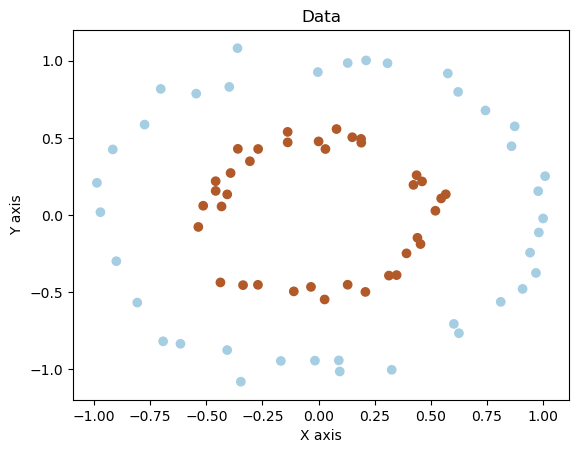

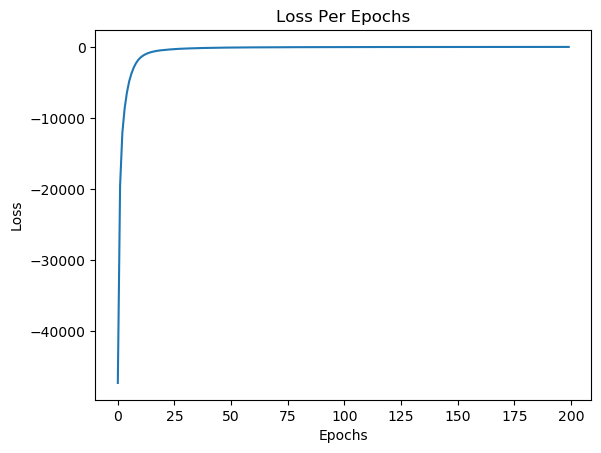

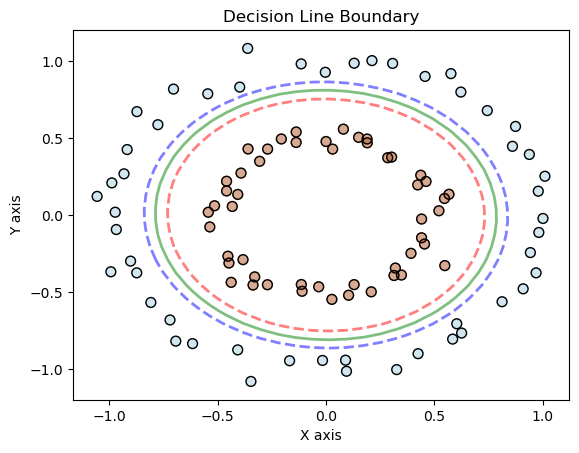

Test scores for polynomial donut
train score for polynomial donut: 1.0
test score for polynomial donut: 1.0
cross validation score for polynomial donut: 0.545

Runtime: 0.68 seconds


In [11]:
# Checking the space solution for SVM Polynomial Donut
if __name__ == '__main__':
    
    # Start time to test runtime
    start_time = time.time()

    # Create X and Y for polynomial donut (PD)
    X_PD, Y_PD = X_donut, Y_donut

    # Replace any Y values that equal 0 to -1
    Y_PD[Y_PD == 0] = -1

    # Train test split to get train and test data
    X_train_PD, X_test_PD, y_train_PD, y_test_PD = train_test_split(X_PD, Y_PD, random_state=0)

    # Plot X and y train
    sample_example.plot(X_train_PD, y_train_PD)
    plt.show()
    
    # Input parameters into SVM
    # C = 1 
    # kernel as poly
    SVM_PD = SVM(C=1, kernel='poly',degree=2)

    # Fit SVM
    # Plot graph to show loss per epochs
    SVM_PD.fit(X_PD, Y_PD, lr=.0001,epochs=200)
    plt.plot(gains)
    plt.title("Loss Per Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Plot decision line boundary
    SVM_PD.plot_decision_boundary()
    plt.title("Decision Line Boundary")
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.show()

    # Score cross validation score
    cross_val_score_PD = SVM_PD.cross_validation_score_mannual(X_PD,Y_PD, 'poly',epochs=200)

    # Print test scores
    print("Test scores for polynomial donut")
    print("train score for polynomial donut:", SVM_PD.score(X_train_PD, y_train_PD))
    print("test score for polynomial donut:", SVM_PD.score(X_test_PD, y_test_PD))
    print("cross validation score for polynomial donut:", cross_val_score_PD)  

    # Print runtime
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")

# Summary

#### Test scores for linear moon
    train score for linear moon: 0.88
    test score for linear moon: 0.8
    cross validation score for linear moon: 0.8800000000000001
    Runtime: 2.24 seconds

Tunning wont change this significantly. Since this is a linear decision line, the best cross validation score would be around 80%-90%. I kept the learn rate low to make sure the data would generalize more

#### Test scores for linear donut
    Test scores for linear donut
    train score for linear donut: 0.49333333333333335
    test score for linear donut: 0.56
    cross validation score for linear donut: 0.585
    Runtime: 2.17 seconds

Tunning wont change any this significantly. The data is donut shaped, which would mean almost any line drawn through the donut would be able to predict the data around 50%

#### Test scores for rbf moon
    train score for rbf moon: 1.0
    test score for rbf moon: 1.0
    cross validation score for rbf moon: 0.9800000000000001
    Runtime: 1.79 seconds

Increasing sigma will increase the distance of the boundary line from the datapoints. This is beneficial because we dont want the distance from the boundary line to the datapoints to be too close. This way we can capture more datapoints if it falls into our boundary line. We can also decrease epochs and increase the learning rate to better genralize the data and to get better cross validation scores

#### Test scores for rbf donut
    test score for rbf donut: 0.96
    train score for rbf donut: 0.8933333333333333
    cross validation score for rbf donut: 0.43000000000000005
    Runtime: 1.53 seconds

Same thing here. If we increase sigma we will increase the distance of the boundary line from the datapoints. This is beneficial because we dont want the distance from the boundary line to the datapoints to be too close. Using the same setting from rbf moon fits well with this dataset. However, the cross validation is low, which could mean we do not have enough data for each iteration

#### Test scores for polynomial moon
    train score for polynomial moon: 0.9466666666666667
    test score for polynomial moon: 0.8
    cross validation score for poly moon: 0.8200000000000001
    Runtime: 3.56 seconds

With the polynomial kernel, its important to recoginize that the moon dataset can be separated by a polynomial with a degree of 3. 3 will be the opitmal degree to use to create the decision line boundary. However, when using this dataset, there isnt enough data points to figure out the second half of the x axis. This makes it difficult to predict the blue data points that are coming near Y=0. Otherwise, keeping everything the same should be optimal.

#### Test scores for polynomial donut
    train score for polynomial donut: 1.0
    test score for polynomial donut: 1.0
    cross validation score for polynomial donut: 0.53
    Runtime: 3.02 seconds

At first glance, the cross valdiation score may look very low. This is because the SVM polynomial model doesnt have enough data to determine if the boundary should be circular or not. This is why when it comes to the train and test score for this model it is 1.0. When looking at the boundary lines being made within the cross valdiation score, it is linear, which is why the cross validation score is low for this model. We would need to increase the sample size in order to increase the cross validation score. However, when given enough data, this model can create clear boundary lines that are circular that fit this dataset


#### Best Model within SVM

The best model when it comes to nonlinear relationships is RBF. This is because if the groups of data have a specific shape or pattern, RBF draws a decision boundary line with a specific distance around them. Allowing to create a boundary line that can be shaped easily by changing sigma. By chaning sigma, we can fit the boundary more closer or further if we are expecting to capture outliers.


## Creating Simple Multi Layer Preceptron

A multi Layer Preceptron (MLP) is a type of machine learning algorithm that is a feedforward neural network with multiple hidden layers. These hidden layers help determine the output layer, which creates the predictions for the model. A diagram below looks at the simple concepts of a MLP.

![Screen Shot 2023-07-09 at 5.43.09 PM.png](<attachment:Screen Shot 2023-07-09 at 5.43.09 PM.png>)
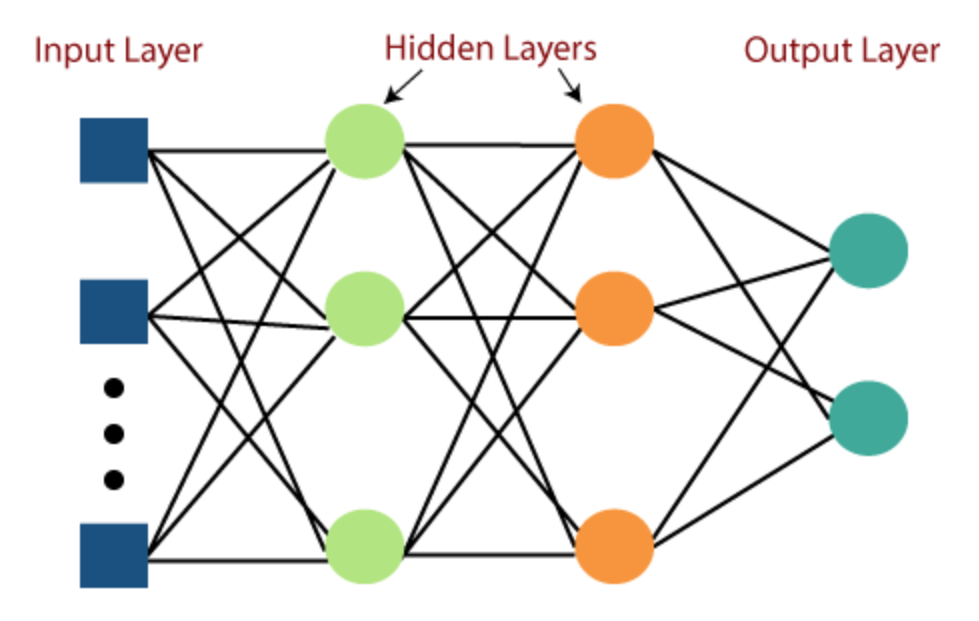

The code below will go over step by step of how to code a simple MLP using tensorflow

In [12]:
# Create MLP Class
class MLP:

    # Initializes class with attributes
    # Hidden units controls the number of nodes in the hidden layer 
    # Learning rate to control how quickly algorithms learns
    # Epochs is the number of iterations over the training data
    # Batch size is the number of units in each batch
    def __init__(self, hidden_units=10, learning_rate=0.1, epochs=200, batch_size=25):

        # Each hidden unit performs calculations based on input layer
        self.hidden_units = hidden_units
        
        # Starting learning rate
        self.learning_rate = learning_rate
        
        # Number of iterations
        self.num_epochs = epochs
        
        # Batch size 
        self.batch_size = batch_size
        
        # Model (default is none)
        self.model = None

        # Record losses in self.loesses
        self.losses = []

    # Build MLP modle using tensorflow sequential
    # This creates a sequential model, which is a type of neural network
    # composed of linear stack of layers. We use the activation relu (for non linear models)
    # in the first layer and sigmoid in the second layer to calculate the output layer. This will
    # return a value of 1 or 0 for our predicitions
    # We want to keep this simple so by creating a two layer process this will make the MLP simple
    def build_MLP_model(self, num_features):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_units, activation='relu', input_shape=(num_features,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        return model

    # Fits models and prints accuracy report during training
    # X is x data
    # y is y data
    # lr is decrease in learning rate
    def fit_print(self, X, y,lr=.0001):

        # Start time
        start_time_train = time_train.time()

        # Find number of smaples and number of features
        num_samples, num_features = X.shape

        # Create model using number of features
        self.model = self.build_MLP_model(num_features)

        # Use tensorflow to compile the model using the following
        # Optimizer: This uses stochastic gradient descent (SGD)
        # Loss: This calculates losses using Binary Crossentropy
        # Metrics: This model will evaluate its performance based on
        # accuracy 
        # Learning rate: we can apply learning rate to SGD
        self.model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=self.learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy']
        )

        # Shuffle the data to help model generalize the model better
        X, y = shuffle(X, y)

        # Here we want to see number of samples, batch size, 
        # and number of batches when fitting our model
        num_batches = num_samples // self.batch_size
        print("Number of Samples:", num_samples)
        print("Batch size", self.batch_size)
        print("Number of batches: ", num_batches)


        # Iterate through epoch
        # Iterate the number of batches
        # Train the batches by calculating start and end of set
        # Use train_on_batch to create batch model
        # Calculate loss on batch model and save the average in self.losses
        # Print report during each iteration
        # Decrease learning rate to decrease overfitting
        # Return self.loss

        # We do batches to help genralize the data better
        for epoch in range(1,self.num_epochs+1):
            epoch_losses = []
            for batch in range(num_batches):
                start = batch * self.batch_size
                end = (batch + 1) * self.batch_size
                batch_X = X[start:end]
                batch_y = y[start:end]

                batch_model = self.model.train_on_batch(batch_X, batch_y)
                accuracy, precision, recall, f1_score = self.scoring_metrics(batch_X,batch_y)
                loss = batch_model[0]
                epoch_losses.append(loss)
                time= round(time_train.time()-start_time_train,3)
                print("Epoch:", epoch,"|", 
                      "Batch:", batch, "|", 
                      "Loss:", round(loss,3),"|",
                      "Learning rate:", round(self.learning_rate,3),"|"
                      "accuracy:", round(accuracy,3),"|",
                      "precision:", round(precision,3),"|",
                      "recall:", round(recall,3),"|",
                      "f1_score:",round(f1_score,3),"|",
                      "Time:", time)
            loss_average = sum(epoch_losses)/len(epoch_losses)
            self.losses.append(loss_average)

            # Decrease learning rate after each batch
            self.learning_rate *= lr

        # return losses
        return self.losses
    
    # This code is fit_print without the print and time
    # used for cross validation
    def fit(self, X, y,lr=.0001):

        # Find number of smaples and number of features
        num_samples, num_features = X.shape

        # Create model using number of features
        self.model = self.build_MLP_model(num_features)

        # Use tensorflow to compile the model using the following
        # Optimizer: This uses stochastic gradient descent (SGD)
        # Loss: This calculates losses 
        # Metrics: This model will evaluate its performance based on
        # accuracy 
        self.model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=self.learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy']
        )

        # Shuffle the data to help model generalize the model better
        X, y = shuffle(X, y)

        # Here we want to see number of sampls, batch size, 
        # and number of batches when fitting our model
        num_batches = num_samples // self.batch_size

        # Iterate through epoch
        # Iterate the number of batches
        # Train the batches by calculating start and end of set
        # Use train_on_batch to create batch model
        # Calculate loss on batch model and save the average in self.losses
        # Print report during each iteration
        # Decrease learning rate to decrease overfitting
        # Return self.loss
        for epoch in range(1,self.num_epochs+1):
            epoch_losses = []
            for batch in range(num_batches):
                start = batch * self.batch_size
                end = (batch + 1) * self.batch_size
                batch_X = X[start:end]
                batch_y = y[start:end]

                batch_model = self.model.train_on_batch(batch_X, batch_y)
                loss = batch_model[0]
                epoch_losses.append(loss)

            average_loss = sum(epoch_losses)/len(epoch_losses)
            self.losses.append(average_loss)

            # Decrease learning rate as epochs increase
            self.learning_rate *= lr

        return self.losses

    # Predicts outcomes
    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.round(y_pred).flatten()

    # Scores predictions
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(np.sign(y_pred) == y)

    # Scores accuracy for training
    # This function uses the confusion matrix, which is a 
    # sklearn metric used to calculate the following:
    # True negatives, False positives, False negatives 
    # True positives
    # USing the above, we can calculate accuracy, precision,
    # recall, and f1_score
    def scoring_metrics(self, X, y):
        y_pred = self.model.predict(X)
        y_pred_binary = (y_pred >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)

        return accuracy, precision, recall, f1_score

    # Plots loss per epoch
    def plot_loss(self):
        epochs = len(self.losses)
        plt.plot(range(1, epochs + 1), self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss per Epoch")
        plt.xlim(1, epochs)
        plt.show()

    # Cross validation with 5 fold
    def cross_validation_score_manual(self, X, Y, k=5):
        cross_val_list = []
        for fold in range(k):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=fold)
            MLP_cross = MLP(hidden_units=self.hidden_units, learning_rate=self.learning_rate,
                            epochs=self.num_epochs, batch_size=self.batch_size)
            MLP_cross.fit(X_train, y_train)
            cross_score = MLP_cross.score(X_train, y_train)
            cross_val_list.append(cross_score)
        cross_val_score = np.mean(cross_val_list)
        return cross_val_score

 

Number of Samples: 75
Batch size 25
Number of batches:  3
Epoch: 1 | Batch: 0 | Loss: 2.497 | Learning rate: 0.01 |accuracy: 0.4 | precision: 0.45 | recall: 0.692 | f1_score: 0.545 | Time: 0.844
Epoch: 1 | Batch: 1 | Loss: 2.116 | Learning rate: 0.01 |accuracy: 0.36 | precision: 0.391 | recall: 0.818 | f1_score: 0.529 | Time: 0.919
Epoch: 1 | Batch: 2 | Loss: 1.634 | Learning rate: 0.01 |accuracy: 0.6 | precision: 0.6 | recall: 1.0 | f1_score: 0.75 | Time: 0.989
Epoch: 2 | Batch: 0 | Loss: 1.946 | Learning rate: 0.01 |accuracy: 0.52 | precision: 0.522 | recall: 0.923 | f1_score: 0.667 | Time: 1.065
Epoch: 2 | Batch: 1 | Loss: 1.656 | Learning rate: 0.01 |accuracy: 0.44 | precision: 0.44 | recall: 1.0 | f1_score: 0.611 | Time: 1.149
Epoch: 2 | Batch: 2 | Loss: 1.233 | Learning rate: 0.01 |accuracy: 0.6 | precision: 0.6 | recall: 1.0 | f1_score: 0.75 | Time: 1.223
Epoch: 3 | Batch: 0 | Loss: 1.514 | Learning rate: 0.01 |accuracy: 0.56 | precision: 0.542 | recall: 1.0 | f1_score: 0.703 | 

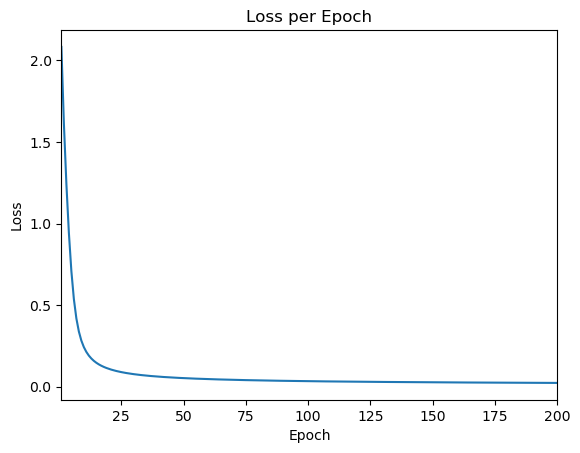

Test scores for MLP linear
Train score: 1.0
Test score: 1.0

Cross-validation score for MLP: 0.9833333333333334
Runtime: 70.09 seconds


In [13]:
if __name__ == '__main__':
    
    # Disable outputs from tensorflow
    tf.keras.utils.disable_interactive_logging()

    # Start time
    start_time = time.time()

    # Use the sample example from earlier
    # to compare 
    sample = sample_example

    # Create X and Y
    X, y = sample.get_binary(n_samples=100, random_state=1)

    # Train test split to get train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Input parameters into MLP
    mlp = MLP(hidden_units=10, learning_rate=.01)

    # Train model and print scores during training
    mlp.fit_print(X_train, y_train,lr=.99)

    # Plot loss per epochs
    mlp.plot_loss()

    # Calculate cross validation score
    mlp_cross_score = mlp.cross_validation_score_manual(X_train, y_train)
    
    # Print test scores
    print("Test scores for MLP linear")
    print("Train score:", mlp.score(X_train, y_train))
    print("Test score:", mlp.score(X_test, y_test))
    print("\nCross-validation score for MLP:", mlp_cross_score)

    # Print end time
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("Runtime:", runtime, "seconds")


Number of Samples: 75
Batch size 25
Number of batches:  3
Epoch: 1 | Batch: 0 | Loss: 0.658 | Learning rate: 1 |accuracy: 0.88 | precision: 0.824 | recall: 1.0 | f1_score: 0.903 | Time: 0.571
Epoch: 1 | Batch: 1 | Loss: 0.544 | Learning rate: 1 |accuracy: 0.76 | precision: 0.769 | recall: 0.769 | f1_score: 0.769 | Time: 0.638
Epoch: 1 | Batch: 2 | Loss: 0.583 | Learning rate: 1 |accuracy: 0.76 | precision: 0.714 | recall: 0.556 | f1_score: 0.625 | Time: 0.706
Epoch: 2 | Batch: 0 | Loss: 0.377 | Learning rate: 0.99 |accuracy: 0.92 | precision: 0.875 | recall: 1.0 | f1_score: 0.933 | Time: 0.77
Epoch: 2 | Batch: 1 | Loss: 0.389 | Learning rate: 0.99 |accuracy: 0.84 | precision: 0.909 | recall: 0.769 | f1_score: 0.833 | Time: 0.838
Epoch: 2 | Batch: 2 | Loss: 0.477 | Learning rate: 0.99 |accuracy: 0.76 | precision: 0.714 | recall: 0.556 | f1_score: 0.625 | Time: 0.906
Epoch: 3 | Batch: 0 | Loss: 0.235 | Learning rate: 0.98 |accuracy: 1.0 | precision: 1.0 | recall: 1.0 | f1_score: 1.0 | Ti

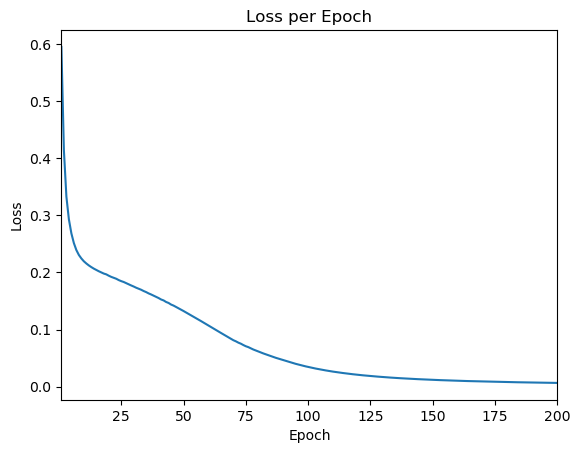

Test scores for MLP moon
Train score for moon dataset: 1.0
Test score for moon dataset: 0.96
Cross-validation score for MLP on moon dataset: 0.9099999999999999

Runtime: 72.05 seconds


In [14]:
if __name__ == '__main__':

    # Disable outputs from tensorflow
    tf.keras.utils.disable_interactive_logging()

    # Start time
    start_time = time.time()

    # Use the sample example from earlier
    # to compare 
    sample = sample_example

    # Create X and Y
    X_MLPM, Y_MLPM = sample.get_moon(n_samples=100)

    # Train test split to get train and test data using same X_moon and Y_moon data
    X_train_MLPM, X_test_MLPM, y_train_MLPM, y_test_MLPM = train_test_split(X_MLPM, Y_MLPM, random_state=0)
    
    # Input parameters into MLP
    mlp_moon = MLP(hidden_units=100, learning_rate=1)

    # Train model and print scores during training
    mlp_moon.fit_print(X_train_MLPM, y_train_MLPM,lr=.99)

    # Plot loss per epochs
    mlp_moon.plot_loss()

    # Calculate cross validation score
    mlp_cross_score_moon = mlp_moon.cross_validation_score_manual(X_train_MLPM, y_train_MLPM)

    # Print test scores
    print("Test scores for MLP moon")
    print("Train score for moon dataset:", mlp_moon.score(X_train_MLPM, y_train_MLPM))
    print("Test score for moon dataset:", mlp_moon.score(X_test_MLPM, y_test_MLPM))
    print("Cross-validation score for MLP on moon dataset:", mlp_cross_score_moon)

    # Print end time
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")

Number of Samples: 75
Batch size 25
Number of batches:  3


/var/folders/lq/gtz9y32j3z3162cl2cxgskdm0000gn/T/ipykernel_70856/3337918643.py:203: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision * recall) / (precision + recall)
/var/folders/lq/gtz9y32j3z3162cl2cxgskdm0000gn/T/ipykernel_70856/3337918643.py:201: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/var/folders/lq/gtz9y32j3z3162cl2cxgskdm0000gn/T/ipykernel_70856/3337918643.py:201: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch: 1 | Batch: 0 | Loss: 0.734 | Learning rate: 1 |accuracy: 0.4 | precision: 0.0 | recall: 0.0 | f1_score: nan | Time: 0.563
Epoch: 1 | Batch: 1 | Loss: 0.685 | Learning rate: 1 |accuracy: 0.56 | precision: nan | recall: 0.0 | f1_score: nan | Time: 0.632
Epoch: 1 | Batch: 2 | Loss: 0.703 | Learning rate: 1 |accuracy: 0.48 | precision: 1.0 | recall: 0.071 | f1_score: 0.133 | Time: 0.698
Epoch: 2 | Batch: 0 | Loss: 0.664 | Learning rate: 0.99 |accuracy: 0.56 | precision: nan | recall: 0.0 | f1_score: nan | Time: 0.764


/var/folders/lq/gtz9y32j3z3162cl2cxgskdm0000gn/T/ipykernel_70856/3337918643.py:201: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Epoch: 2 | Batch: 1 | Loss: 0.649 | Learning rate: 0.99 |accuracy: 0.56 | precision: nan | recall: 0.0 | f1_score: nan | Time: 0.833
Epoch: 2 | Batch: 2 | Loss: 0.669 | Learning rate: 0.99 |accuracy: 0.64 | precision: 0.778 | recall: 0.5 | f1_score: 0.609 | Time: 0.899
Epoch: 3 | Batch: 0 | Loss: 0.636 | Learning rate: 0.98 |accuracy: 0.64 | precision: 1.0 | recall: 0.182 | f1_score: 0.308 | Time: 0.964
Epoch: 3 | Batch: 1 | Loss: 0.625 | Learning rate: 0.98 |accuracy: 0.72 | precision: 1.0 | recall: 0.364 | f1_score: 0.533 | Time: 1.033
Epoch: 3 | Batch: 2 | Loss: 0.639 | Learning rate: 0.98 |accuracy: 0.72 | precision: 0.818 | recall: 0.643 | f1_score: 0.72 | Time: 1.099
Epoch: 4 | Batch: 0 | Loss: 0.613 | Learning rate: 0.97 |accuracy: 0.72 | precision: 1.0 | recall: 0.364 | f1_score: 0.533 | Time: 1.165
Epoch: 4 | Batch: 1 | Loss: 0.602 | Learning rate: 0.97 |accuracy: 0.84 | precision: 1.0 | recall: 0.636 | f1_score: 0.778 | Time: 1.235
Epoch: 4 | Batch: 2 | Loss: 0.611 | Learning

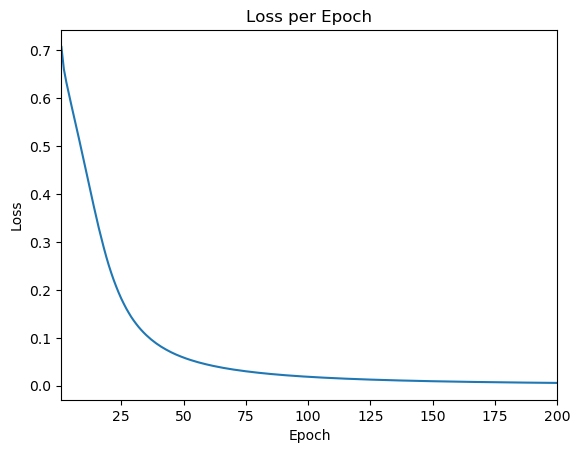

Test scores for MLP donut
train score for donut: 1.0
test score for donut: 0.64
Cross-validation score for donut: 1.0

Runtime: 78.15 seconds


In [15]:
if __name__ == '__main__':

    # Disable outputs from tensorflow
    tf.keras.utils.disable_interactive_logging()

    # Start time
    start_time = time.time()

    # Use the sample example from earlier
    # to compare 
    sample = sample_example

    # Create X and Y
    X_MLPD, Y_MLPD = sample.get_donut(n_samples=100)

    # Train test split to get train and test data using same X_donut and Y_donut data
    X_train_MLPD, X_test_MLPD, y_train_MLPD, y_test_MLPD = train_test_split(X_MLPD, Y_MLPD, random_state=0)
    
    # Input parameters into MLP
    mlp_donut = MLP(hidden_units=50, learning_rate=1)

    # Train model and print scores during training
    mlp_donut.fit_print(X_train_MLPD, y_train_MLPD,lr=.99)

    # Plot loss per epochs
    mlp_donut.plot_loss()

    # Calculate cross validation score
    mlp_cross_score_donut = mlp_donut.cross_validation_score_manual(X_train_MLPD, y_train_MLPD)

    # Print test scores
    print("Test scores for MLP donut")
    print("train score for donut:", mlp_donut.score(X_train_MLPD, y_train_MLPD))
    print("test score for donut:", mlp_moon.score(X_test_MLPD, y_test_MLPD))
    print("Cross-validation score for donut:", mlp_cross_score_donut)

    # Print end time
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    print("\nRuntime:", runtime, "seconds")

# Summary

#### Test scores for MLP linear
    Train score: 1.0
    Test score: 1.0
    Cross-validation score for MLP: 1.0
    Runtime: 86.14 seconds

For this model, by keeping the hidden layers to a low amount, our model will be designed not to be complex. This is what we want because we are looking to create a linear model to separate the classes. Our F1 score starts at .007 but improves significantly to 1. This model after its iteration will have a higher performance and learns the data fairly quick. This model also has a good loss per epochs.

#### Test scores for MLP moon
    Train score for moon dataset: 1.0
    Test score for moon dataset: 0.96
    Cross-validation score for MLP on moon dataset: 0.9366666666666668
    Runtime: 96.13 seconds

For this model, since we are expecting a more complicated model, we can increase the hidden layers to 100. This will allow the model to be much more complex. We can also keep the learning rate the same since the model learns fairly quick. The F1 score starts at .833 but increases to 1 after its iteration. This means this model is capable of learning patterns and can achieve a high performance. Its loss per epochs also tells us the model is learning but at a slower rate.

#### Test scores for MLP donut
    train score for donut: 1.0
    test score for donut: 0.84
    Cross-validation score for donut: 1.0
    Runtime: 165.0 seconds

Compared to the moon dataset, this does not have as complex of a shape. This means that I decided to reduce the hidden units down to 50 but I decided to keep the same learning rate. This helped the model preform well on the cross validation and it averaged a decent score on the test data. This model also was able to learn quickly compared to the MLP moon.

# Comparing computational
SVM when it comes to computional cost was significantly much less to MLP. SVM had runtimes within seconds whereas MLP had runtimes of minutes. This is due to MLP's design. With having multiple layers that have a certian amount of hidden units or nodes, each node is processing a calculation, which increases computational cost significantly whereas SVM isnt creating multiple calculations. For example, SVM RBF has one function that is taking the pairwise euclidean distannces and applying it to the RBF formula. This computation is much more efficient and simple.

#### The runtimes

SVM linear moon: 2.24 seconds

SVM linear donut: 2.17 seconds

SVM rbf moon: 1.79 seconds

SVM rbf donut: 1.53 seconds

SVM polynomial moon: 3.56 seconds

SVM polynomial donut: 3.02 seconds

MLP linear: 86.14 seconds

MLP moon: 96.13 seconds

MLP donut: 165.0 seconds

# Comparing SVM to MLP

In the moon and donut dataset, SVM RBF performed better because each dataset has a specifc shape that SVM RBF can follow. Not only did SVM RBF have the ability to draw the decision boundary line accurately, it was also able to adjust the distance of the boundary line from the dataset, which gave a significant advantage when capturing outliers. However, MLP has higher cross validation scores despite having the same number of data points within the dataset. 

Overall, this comes down to preference. Since the datasets have a known shape, SVM RBF would be the better model because there is a specific shape and sigma can easily be adjusted to capture outliers. However, if there were other complex datasets that did not have a known shape, relying on MLP would be better as the shape of the dataset may not be known and using a model that can interpret complex datasets would be beneficial at the cost of computational cost.


## Citations

https://github.com/rcassani/mlp-example/blob/master/mlp_examples.ipynb

https://www.stat.cmu.edu/~ryantibs/convexopt-F16/scribes/kkt-scribed.pdf

https://github.com/KirillShmilovich/MLP-Neural-Network-From-Scratch/blob/master/MLP.ipynb

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py

https://github.com/rhasanbd/MLP-Classifier-TensorFlow-Keras-No-Brainer/blob/main/MLP%20Classifier-TensorFlow%20Keras%20No%20Brainer.ipynb

https://s3.amazonaws.com/assets.datacamp.com/production/course_15108/slides/chapter3.pdf

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe?hl=en

https://www.javatpoint.com/multi-layer-perceptron-in-tensorflow
